# Tensorflow V2로 학습한 모델을 SageMaker로 배포하기

본 노트북에서는 학습된 모델을 SageMaker endpoint로 배포하는 프로세스를 살펴봅니다. [첫번째 노트북](1.mnist_train.ipynb)에서 매직명령어 %store% 로 저장했던 `model_data`의 모델 아티팩트를 로드하여 사용합니다. (만약 이전에 생성한 모델 아티팩트가 없다면 공개 S3 버킷에서 해당 파일을 다운로드하게 됩니다.)

In [3]:
import sagemaker 
sagemaker.__version__

'2.45.0'

In [32]:
# setups

import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker import get_execution_role, Session
import boto3

# Get global config
with open('code/config.json', 'r') as f:
    CONFIG=json.load(f)

sess = Session()
role = get_execution_role()

%store -r tf_mnist_model_data


# store -r 시도 후 모델이 없는 경우 publc s3 bucket에서 다운로드
try: 
    tf_mnist_model_data
except NameError:
    import json
    # copy a pretrained model from a public public to your default bucket
    s3 = boto3.client('s3')
    bucket = CONFIG['public_bucket']
    key = 'datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz'
    s3.download_file(bucket, key, 'model.tar.gz')
    tf_mnist_model_data = sess.upload_data(
        path='model.tar.gz', bucket=sess.default_bucket(), key_prefix='model/tensorflow')
    os.remove('model.tar.gz')



In [19]:
del tf_mnist_model_data

In [33]:
print(tf_mnist_model_data)

s3://sagemaker-ap-northeast-1-308961792850/tensorflow/mnist/tensorflow-training-2021-07-16-11-57-03-562/model.tar.gz


## TensorFlow Model Object

SageMaker에서 제공하는 `TensorFlowModel` 클래스는 여러분의 모델 아티팩트를 이용하여 추론을 실행하는 환경을 정의하도록 해 줍니다. 이는 [첫번째 노트북](1.mnist_train.ipynb)에서 `TensorFlow` estimator를 정의했던 것과 유사한 방식으로, 학습된 모델을 SageMaker에서 호스팅하도록 도커 이미지를 정의하는 하이레벨 API입니다. 

해당 API를 통해 모델을 추론할 환경을 설정하고 나면 SageMaker에서 관리하는 EC2 인스턴스에서 SageMaker Endpoint 형태로 실행할 수 있습니다. SageMaker Endpoint는 학습된 모델을 RESTful API를 통해 추론하도록 하는 컨테이너기반 환경입니다. 

`TensorFlowModel` 클래스를 초기화할 때 사용되는 파라미터들은 다음과 같습니다.
- role: AWS 리소스 사용을 위한 An IAM 역할(role) 
- model_data: 압축된 모델 아티팩트가 있는 S3 bucket URI. local mode로 실행시에는 로컬 파일경로 사용가능함
- framework_version: 사용하 프레임워크의 버전
- py_version: 파이썬 버전

In [42]:

model = TensorFlowModel(
    role=role,
    model_data=tf_mnist_model_data,
    framework_version='2.3.1'
)


## 추론 컨테이너 실행

`TensorFlowModel` 클래스가 초기화되고 나면 `deploy`메소드를 이용하여 호스팅용 컨테이너를 실행할 수 있습니다.  

`deploy`메소드 실행시 사용되는 파라미터들은 다음과 같습니다.
- initial_instance_count: 호스팅 서비스에 사용할 SageMaker 인스턴스의 숫자 
- instance_type: 호스팅 서비스를 실행할 SageMaker 인스턴스 타입. 이 값을 `local` 로 선택하면 로컬 인스턴스(SageMaker Jupyter notebook)에 호스팅 컨테이너가 실행됩니다. local mode는 주로 디버깅 단계에서 사용하게 됩니다. 

<span style="color:red"> 주의 : SageMaker Studio 환경에서는 local mode 가 지원되지 않습니다. </span>

In [43]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

instance_type='ml.c4.xlarge'

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

## SageMaker endpoint를 이용한 예측 실행

`model.deploy(...)`에 의해 리턴된 `Predictor` 인스턴스를 이용하여 예측 요청을 endpoint에 보낼 수 있습니다. 이 경우 모델은 정규화 된 배치 이미지를 받습니다.


In [44]:
# use some dummy inputs
import numpy as np

dummy_inputs = {
    'instances': np.random.rand(4, 28, 28, 1)
}

res = predictor.predict(dummy_inputs)
print(res)

{'predictions': [[-3.79073334, 0.820336223, 4.07582188, 5.73694229, -2.32441854, 3.78877211, 1.38228762, 0.446180493, 3.18431354, -0.990055859], [-2.59494328, -0.202590972, 2.57222342, 4.69261074, -3.85817075, 4.03920698, 3.75943542, -0.579069138, 3.04465652, -0.725097597], [-2.26567817, 0.164766416, 3.14051318, 4.99949408, -3.47172809, 4.01756334, 1.0856986, -0.209493652, 2.786623, 0.139719069], [-1.18461144, -0.554233253, 3.67689371, 4.61099911, -3.86431074, 2.57139, 2.54160523, 0.561141074, 1.83413744, -0.68195349]]}


입출력 데이터 포맷이 [TensorFlow Serving REST API](https://www.tensorflow.org/tfx/serving/api_rest)의 `Predict`에서 정의된 request, respoinst 포맷과 일치하는 지 확인합니다. 

예를 들어 본 코드에서 `dummy_inputs`은 `instances`를 키로 하여 배열의 형태로 전달하고 있습니다. 또한 입력데이터는 batch dimension을 포함한 4차원 배열로 구성되어 있습니다.

In [45]:
# Uncomment the following lines to see an example that cannot be processed by the endpoint

#dummy_data = {
#    'instances': np.random.rand(28, 28, 1).tolist()
#}
#print(predictor.predict(inputs))

이제 실제 MNIST 테스트 데이터로 엔드포인트를 호출해 봅니다. 여기서는 MNIST 데이터를 다운로드하고 normalize하기 위해 `code.utils` 의 헬퍼함수를 사용하였습니다.

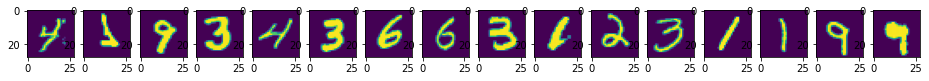

In [46]:
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = '/tmp/data'
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images 
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

모델이 nomalized 된 입력을 받게 되어있으므로 normalize 처리 후 엔디포인트를 호출합니다. 

In [47]:
samples = normalize(samples, axis=(1, 2))
predictions = predictor.predict(
    np.expand_dims(samples, 3) # add channel dim
)['predictions'] 

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)


In [48]:
print("Predictions: ", predictions.tolist())

Predictions:  [4, 2, 9, 3, 4, 3, 6, 6, 3, 6, 2, 3, 1, 1, 9, 9]


## (Optional) 리소스 삭제

엔드 포인트를 사용할 계획이 없으면 리소스를 확보하기 위해 삭제합니다. 로컬을 사용한 경우 포트 8080에서 바운드 된 Docker 컨테이너 (들어오는 요청을 수신하는 포트)를 수동으로 삭제해야합니다.

In [49]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")